# Topic: ASTRAZENECA Vaccine Tweets 

In [1]:
#import the necessary library 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import tweepy as tw 
import json 

import pycountry as pc
import pycountry_convert as pcc


from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
%matplotlib inline 

#Advance Data Visualization 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

In [3]:
# #Twitter Credentials

# credentials={}
# credentials["CONSUMER_KEY"] ="***********CONSUMER_KEY************"
# credentials["CONSUMER_SECRET"] =  "***************CONSUMER_SECRET*****************************"
# credentials["ACESS_TOKEN"] =  "*****************ACESS_TOKEN*************************"
# credentials["ACESS_SECRET"] = "*****************ACESS_SECRET*******************"

In [3]:
# #save the credentials into filename twitter key in json format

# with open ('twitter_keys', 'w') as file:
#     json.dump(credentials,file)

In [159]:
#load the keys for authentication purpose 
with open ('twitter_keys', 'r') as file:
    twt_keys = json.load(file)

# API Authentication 

In [160]:
auth = tw.OAuthHandler(twt_keys['CONSUMER_KEY'], twt_keys['CONSUMER_SECRET'])
auth.set_access_token(twt_keys['ACESS_TOKEN'], twt_keys['ACESS_SECRET'])
api = tw.API(auth, wait_on_rate_limit=True)

## Query for Tweets Extraction 

In [161]:
search_words = "astraZeneca covid"
date_since = "2021-04-12"

# Collect tweets
tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(3500)

In [171]:
tweet_copy = []

for tweet in tweets:
    tweet_copy.append(tweet) 

In [172]:
#create a dictionary 
data_dict = {'user_name':[], 'user_date':[], 'text':[], 'favorite_count':[], 'location': [], 'sources': [], 'followers':[], 'ver_acct':[]}

#pandas dataframe set up
for tweet in tweet_copy:
    data_dict['user_name'].append(tweet.user.name)
    data_dict['user_date'].append(tweet.created_at)
    data_dict['text'].append(tweet.text)
    data_dict['favorite_count'].append(tweet.user.favourites_count)
    data_dict['location'].append(tweet.user.location)
    data_dict['sources'].append(tweet.source)
    data_dict['followers'].append(tweet.user.followers_count)
    data_dict['ver_acct'].append(tweet.user.verified)

In [55]:
df_tweet = pd.DataFrame(data_dict)

In [56]:
df_tweet.shape

(990, 8)

In [57]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_name       990 non-null    object        
 1   user_date       990 non-null    datetime64[ns]
 2   text            990 non-null    object        
 3   favorite_count  990 non-null    int64         
 4   location        990 non-null    object        
 5   sources         990 non-null    object        
 6   followers       990 non-null    int64         
 7   ver_acct        990 non-null    bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(4)
memory usage: 55.2+ KB


In [58]:
df_tweet.head()

,user_name,user_date,text,favorite_count,location,sources,followers,ver_acct
0,IT’S TIME!!!📣🔊🔔🏳️‍🌈,2021-05-11 16:26:11,RT @gtlem: BREAKING - Jason Kenney UCP Government\n\nBANS AstraZeneca - despite Alberta having the HIGHEST Covid19 rate in ALL of North Ameri…,66368,,Twitter Web App,1305,False
1,Angella,2021-05-11 16:26:05,RT @RobertKennedyJr: EU regulators are calling on Pfizer + Moderna to provide additional data related to companies’ COVID vaccines + a pote…,1433,Nelson BC Canada,Twitter Web App,528,False
2,Christine Huddleston,2021-05-11 16:25:58,RT @gtlem: BREAKING - Jason Kenney UCP Government\n\nBANS AstraZeneca - despite Alberta having the HIGHEST Covid19 rate in ALL of North Ameri…,3294,Toronto,Twitter for Android,14910,False
3,Brittlestar,2021-05-11 16:25:54,RT @heysciencesam: I know there are a lot of people who recently got the AstraZeneca vaccine who feel ... snubbed ... after last week's com…,160105,"Stratford, ON",Twitter for iPhone,84359,True
4,LenaPoros,2021-05-11 16:25:46,RT @Reuters_Health: Brazilian states halted vaccination of pregnant women on Tuesday after a death in Rio de Janeiro led health regulator A…,16566,"Roma, Lazio",Twitter for Android,169,False


In [59]:
## save the datframe to csv file
df_tweet.to_csv('tweet_extract2.csv', index=False)

## Data Wrangling and Cleaning 

In [232]:
df_twt = pd.read_csv('tweet_extract2.csv', parse_dates=['user_date'])

In [233]:
df_twt.head()

,user_name,user_date,text,favorite_count,location,sources,followers,ver_acct
0,IT’S TIME!!!📣🔊🔔🏳️‍🌈,2021-05-11 16:26:00,RT @gtlem: BREAKING - Jason Kenney UCP Government\n\nBANS AstraZeneca - despite Alberta having the HIGHEST Covid19 rate in ALL of North Ameri…,66368,NaN,Twitter Web App,1305,False
1,Angella,2021-05-11 16:26:00,RT @RobertKennedyJr: EU regulators are calling on Pfizer + Moderna to provide additional data related to companies’ COVID vaccines + a pote…,1433,Nelson BC Canada,Twitter Web App,528,False
2,Christine Huddleston,2021-05-11 16:25:00,RT @gtlem: BREAKING - Jason Kenney UCP Government\n\nBANS AstraZeneca - despite Alberta having the HIGHEST Covid19 rate in ALL of North Ameri…,3294,Toronto,Twitter for Android,14910,False
3,Brittlestar,2021-05-11 16:25:00,RT @heysciencesam: I know there are a lot of people who recently got the AstraZeneca vaccine who feel ... snubbed ... after last week's com…,160105,"Stratford, ON",Twitter for iPhone,84359,True
4,LenaPoros,2021-05-11 16:25:00,RT @Reuters_Health: Brazilian states halted vaccination of pregnant women on Tuesday after a death in Rio de Janeiro led health regulator A…,16566,"Roma, Lazio",Twitter for Android,169,False


In [234]:
df_twt.isnull().any()

user_name         False
user_date         False
text              False
favorite_count    False
location           True
sources           False
followers         False
ver_acct          False
dtype: bool

In [235]:
#function for missing data
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [236]:
missing_data(df_twt)

,user_name,user_date,text,favorite_count,location,sources,followers,ver_acct
Total,0,0,0,0,281,0,0,0
Percent,0.0,0.0,0.0,0.0,28.383838,0.0,0.0,0.0
Types,object,datetime64[ns],object,int64,object,object,int64,bool


In [237]:
df_twt.groupby('sources').count()

,user_name,user_date,text,favorite_count,location,followers,ver_acct
sources,,,,,,,
Blog2Social APP,1,1,1,1,0,1,1
Buffer,1,1,1,1,1,1,1
CRWE World,1,1,1,1,1,1,1
CanNewsBot,2,2,2,2,2,2,2
Carona Updates,1,1,1,1,0,1,1
Devdiscourse News Desk,1,1,1,1,1,1,1
Echobox,9,9,9,9,7,9,9
Falcon Social Media Management,1,1,1,1,1,1,1
Hootsuite Inc.,5,5,5,5,4,5,5


In [238]:
df_twt['sources'].value_counts().sort_values(ascending=False)[5:]

Echobox                            9
Hootsuite Inc.                     5
WordPress.com                      5
SocialFlow                         5
Microsoft Power Platform           4
IFTTT                              4
Infotel Multimedia News            4
CanNewsBot                         2
Salesforce - Social Studio         2
True Anthem                        2
histeriusapp                       2
Zapier.com                         2
Falcon Social Media Management     1
Newsfilter.io                      1
Republicworld                      1
Devdiscourse News Desk             1
happyhomeinc                       1
Buffer                             1
TheDokApp                          1
Twitter for Mac                    1
Nairametrics                       1
CRWE World                         1
Motivational App                   1
What´s new from my24group.com      1
Ventacademy Publisher              1
LeafScores                         1
Tweetbot for iΟS                   1
C

In [239]:
## setting up the list for other minor source
replace = ["WordPress.com"                    ,
"SocialFlow"                       ,
"IFTTT"                            ,
"Microsoft Power Platform"         ,
"Infotel Multimedia News"          ,
"Zapier.com"                       ,
"histeriusapp"                     ,
"CanNewsBot"                       ,
"Salesforce - Social Studio"       ,
"True Anthem"                      ,
"Newsfilter.io"                    ,
"Blog2Social APP"                  ,
"happyhomeinc"                     ,
"isearch247"                       ,
"LeafScores"                       ,
"Falcon Social Media Management"   ,
"Twitter for Mac"                  ,
"CRWE World"                       ,
"Motivational App"                 ,
"What´s new from my24group.com"    ,
"Republicworld"                    ,
"TheDokApp"                        ,
"OxfordBlue-Twitter"               ,
"Buffer"                           ,
"Market Flash"                     ,
"Nairametrics"                     ,
"Vaccine Hunter Canada"            ,
"Carona Updates"                   ,
"Twitterrific for Mac"             ,
"Tweetbot for iΟS"                 ,
"Devdiscourse News Desk"           ,
"Ventacademy Publisher"]

In [240]:
df_twt["sources"] = df_twt['sources'].replace(to_replace = replace, value="Others")

<AxesSubplot:title={'center':'Sources for Tweets/Device'}, xlabel='sources', ylabel='count'>

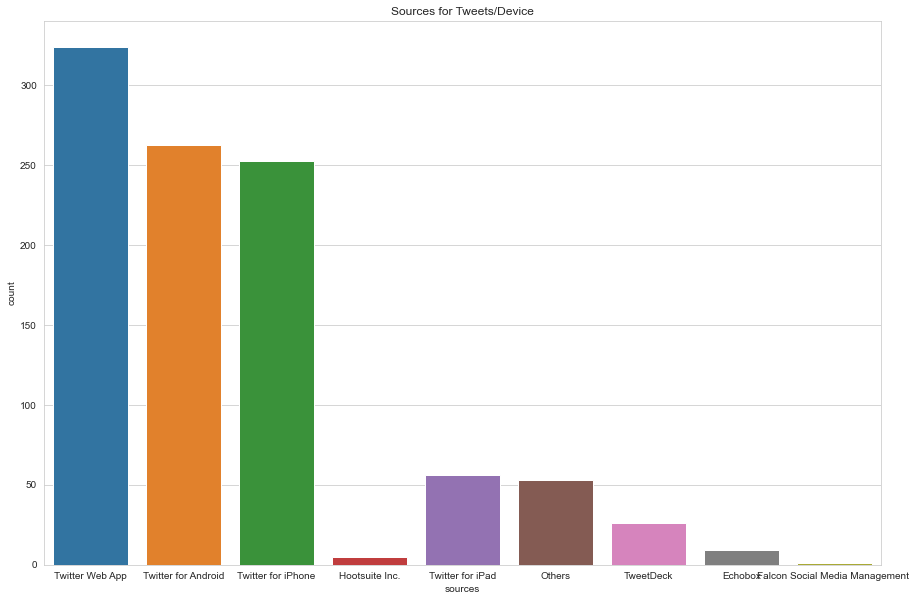

In [241]:
plt.figure(figsize=(15, 10))
plt.title("Sources for Tweets/Device")
sns.countplot(x="sources", data=df_twt)

The graph above shows that the most used device is **Web App** and the source that can be trusted lies between this three
+ **Twitter for Android**
- **Twitter for Web App** and
- **Twitter for IPhone**

# Drop Null or Empty value

In [242]:
#remove the nan from the column location and sources

df_12 = df_twt.dropna(axis=0).reset_index(drop=True)

In [243]:
df_12.sample(2)

,user_name,user_date,text,favorite_count,location,sources,followers,ver_acct
697,L,2021-05-11 14:14:00,RT @ctvwinnipeg: BREAKING: Alberta Health confirms it will withhold its current supply of the AstraZeneca COVID-19 vaccine for second doses…,3928,Friendly Manitoba,Twitter for iPhone,47,False
545,Monica Ferris,2021-05-07 14:42:00,"RT @RobynUrback: I don't get this. Alberta's case rate is through the roof, highest in Canada. AstraZeneca's vaccine works. Why not let peo…",19427,Toronto,Twitter for Android,544,False


## Split Location column into country and cities 
considering the column location, it most of the location contain country and cities. hence we spilit it for prominent insight into country and cities with prevalent tweet.

In [244]:
## this line of code split the columns by comma and then by space to get a reasonable counntry out of the location

df_12['country'] = df_12['location'].apply(lambda x: x.split(',')[-1]).apply(lambda x: x.split(' ')[-1])

In [245]:
## replace the incorrect location with the correct one
df_12['country'] = df_12['country'].replace({ "UK":"United Kingdom", "Kingdom":"United Kingdom", "Africa":"Nigeria", "Ontario":"Canada", 
                                              "Alberta":"Canada", "England":"United Kingdom", "London":"United Kingdom", "Ottawa":"Canada",
                                              "Calgary":"Italy", "Polska":"Poland", "Dublin":"Ireland", "Yorkshire":"United Kingdom", 
                                              "Manchester":"United Kingdom", "Toronto":"Canada", "States":"United States","Vancouver":"Canada", 
                                              "NYC":"United States", "TX":"United States", "Orleans":"United States", "DC":"United States", 
                                              "nigeria":"Nigeria", "NIGERIA":"Nigeria", "AFRICA":"Nigeria", "Abuja":"Nigeria",
                                              "Delhi":"Nigeria", "australia":"Australia", "Madrid":"Spain", "Paris":"France", "Britain":"United Kingdom",
                                              "USA": "United States", "Italia": "Italy", "NY":"United States","World":"Canada", 
                                              "CA":"Canada", "canada":"Canada", "Brighton/Cambridge":"United Kingdom", "ON":"Canada",
                                              "Earth":"United States","BC":"United States", "B.C.":"United States", "Kenney":"United States",
                                              "Manitoba":"United States", "City":"Columbia"})

In [246]:
## assign the country code ISO 3166-1 alpha-3 to the countries for map plotting
## assign continent code to the coutries
iso_ = []
conti = []
for i in df_12['country']:
    try:
        iso_.append(pcc.country_name_to_country_alpha3(cn_name=i, cn_name_format="default"))
        conti.append(pcc.country_alpha2_to_continent_code(pcc.country_name_to_country_alpha2(cn_name=i, cn_name_format="default")))
    except:
        iso_.append(np.nan)
        conti.append(np.nan)

In [247]:
df_12['iso_alpha'] = iso_
df_12['continent'] = conti

In [248]:
## create a column to assign tweet count to thier respective country
df_12["tweet_count"] = df_12["country"].map(df_12["country"].value_counts())

In [249]:
countries = df_12.dropna()
countries.shape

(462, 12)

In [250]:
countries.head()

,user_name,user_date,text,favorite_count,location,sources,followers,ver_acct,country,iso_alpha,continent,tweet_count
0,Angella,2021-05-11 16:26:00,RT @RobertKennedyJr: EU regulators are calling on Pfizer + Moderna to provide additional data related to companies’ COVID vaccines + a pote…,1433,Nelson BC Canada,Twitter Web App,528,False,Canada,CAN,NA,241
1,Christine Huddleston,2021-05-11 16:25:00,RT @gtlem: BREAKING - Jason Kenney UCP Government\n\nBANS AstraZeneca - despite Alberta having the HIGHEST Covid19 rate in ALL of North Ameri…,3294,Toronto,Twitter for Android,14910,False,Canada,CAN,NA,241
2,Brittlestar,2021-05-11 16:25:00,RT @heysciencesam: I know there are a lot of people who recently got the AstraZeneca vaccine who feel ... snubbed ... after last week's com…,160105,"Stratford, ON",Twitter for iPhone,84359,True,Canada,CAN,NA,241
4,Tjaša Zavrh - Zombi,2021-05-11 16:25:00,"RT @AFP: #BREAKING Slovakia suspends AstraZeneca first-dose Covid jabs, health ministry says, after earlier signalling it was investigating…",125913,Slovenia,Twitter Web App,1297,False,Slovenia,SVN,EU,2
5,Sharon Konechny,2021-05-11 16:25:00,RT @HaveWeAllGoneM1: Ontario likely to mix first and second COVID-19 vaccine doses amid lack of AstraZeneca supply\n\nGreat idea... let's exp…,14340,Canada,Twitter for iPhone,376,False,Canada,CAN,NA,241


### Number of tweets by location(Bubble map)
The map is interactive, hover around the map for details

In [251]:
import plotly.express as px
fig = px.scatter_geo(countries, locations="iso_alpha", color="continent",
                     hover_name="country", size="tweet_count", projection="natural earth")
fig.show()

In [252]:
df = df_12.drop(["iso_alpha", "continent"], axis=1).copy()

In [253]:
df.sample(5)

,user_name,user_date,text,favorite_count,location,sources,followers,ver_acct,country,tweet_count
246,Lord-Lt Bedfordshire,2021-05-11 15:43:00,RT @BLMK_CCG: Due for your second AstraZeneca Covid-19 jab? Is it more than 77 days since your first vaccination?\n\nIf you were unable to ma…,7357,Bedfordshire,Twitter Web App,3054,False,Bedfordshire,1
414,Kim Tom 🏳️‍🌈 #DefendTheDefenders,2021-05-11 15:09:00,"RT @redfishstream: Dozens protested outside the headquarters of vaccine manufacturer AstraZeneca and at the University of Oxford, to demand…",88423,Philippines,Twitter for Android,580,False,Philippines,5
503,Raj Bhagwandin,2021-05-08 14:49:00,"RT @jimsciutto: —&gt;&gt; @SenatorBurr presses WH Covid official on why the US isn’t giving other countries more AstraZeneca vaccine, which he no…",121750,Guyana,Twitter for Android,2985,False,Guyana,1
340,Moses Idiku Odey,2021-05-11 15:24:00,RT @business: Brazil stops giving AstraZeneca's Covid-19 shots to pregnant women as authorities investigate the reported death of a woman i…,119552,"Ikeja, Nigeria",Twitter for Android,3241,False,Nigeria,18
157,Thornback,2021-05-11 15:57:00,"RT @AFP: #BREAKING Slovakia suspends AstraZeneca first-dose Covid jabs, health ministry says, after earlier signalling it was investigating…",180975,"No Name, CO",Twitter Web App,1834,False,CO,2


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_name       709 non-null    object        
 1   user_date       709 non-null    datetime64[ns]
 2   text            709 non-null    object        
 3   favorite_count  709 non-null    int64         
 4   location        709 non-null    object        
 5   sources         709 non-null    object        
 6   followers       709 non-null    int64         
 7   ver_acct        709 non-null    bool          
 8   country         709 non-null    object        
 9   tweet_count     709 non-null    int64         
dtypes: bool(1), datetime64[ns](1), int64(3), object(5)
memory usage: 50.7+ KB


## Clean Up the User_name and Text

In [255]:
#from the previous section we move from dropping the missing value now we want to clean-up the text and user_name column 
#using Regular_Expression 


#Preprocessing for Text:
df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x))  #remove all the url


df['text'] = df['text'].apply(lambda x: re.sub('@[^\s]+', '', x))     #remove twitter handler


df['text'] = df['text'].apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', '', x))  #remove single words 


#Cleaning the User_name
df['user_name'] = df['user_name'].apply(lambda x: ''.join(re.findall(r'\w+', x))) #remove special character from user_name

In [256]:
df.head()

,user_name,user_date,text,favorite_count,location,sources,followers,ver_acct,country,tweet_count
0,Angella,2021-05-11 16:26:00,RT EU regulators are calling on Pfizer + Moderna to provide additional data related to companies’ COVID vaccines +pote…,1433,Nelson BC Canada,Twitter Web App,528,False,Canada,241
1,ChristineHuddleston,2021-05-11 16:25:00,RT BREAKING - Jason Kenney UCP Government\n\nBANS AstraZeneca - despite Alberta having the HIGHEST Covid19 rate in ALL of North Ameri…,3294,Toronto,Twitter for Android,14910,False,Canada,241
2,Brittlestar,2021-05-11 16:25:00,RTknow there arelot of people who recently got the AstraZeneca vaccine who feel ... snubbed ... after last week's com…,160105,"Stratford, ON",Twitter for iPhone,84359,True,Canada,241
3,LenaPoros,2021-05-11 16:25:00,RT Brazilian states halted vaccination of pregnant women on Tuesday afterdeath in Rio de Janeiro led health regulator A…,16566,"Roma, Lazio",Twitter for Android,169,False,Lazio,1
4,TjašaZavrhZombi,2021-05-11 16:25:00,"RT #BREAKING Slovakia suspends AstraZeneca first-dose Covid jabs, health ministry says, after earlier signalling it was investigating…",125913,Slovenia,Twitter Web App,1297,False,Slovenia,2


In [257]:
df['text'] = df['text'].apply(lambda x: x.replace('RT', ''))      #remove the re_tweet

df['text'] = df['text'].apply(lambda x: re.sub(r'\B#\S+', '', x))  #remove the Hastag

In [258]:
df.head()

,user_name,user_date,text,favorite_count,location,sources,followers,ver_acct,country,tweet_count
0,Angella,2021-05-11 16:26:00,EU regulators are calling on Pfizer + Moderna to provide additional data related to companies’ COVID vaccines +pote…,1433,Nelson BC Canada,Twitter Web App,528,False,Canada,241
1,ChristineHuddleston,2021-05-11 16:25:00,BREAKING - Jason Kenney UCP Government\n\nBANS AstraZeneca - despite Alberta having the HIGHEST Covid19 rate in ALL of North Ameri…,3294,Toronto,Twitter for Android,14910,False,Canada,241
2,Brittlestar,2021-05-11 16:25:00,know there arelot of people who recently got the AstraZeneca vaccine who feel ... snubbed ... after last week's com…,160105,"Stratford, ON",Twitter for iPhone,84359,True,Canada,241
3,LenaPoros,2021-05-11 16:25:00,Brazilian states halted vaccination of pregnant women on Tuesday afterdeath in Rio de Janeiro led health regulator A…,16566,"Roma, Lazio",Twitter for Android,169,False,Lazio,1
4,TjašaZavrhZombi,2021-05-11 16:25:00,"Slovakia suspends AstraZeneca first-dose Covid jabs, health ministry says, after earlier signalling it was investigating…",125913,Slovenia,Twitter Web App,1297,False,Slovenia,2


In [259]:
pd.to_datetime(df["user_date"]).dt.date

0      2021-05-11
1      2021-05-11
2      2021-05-11
3      2021-05-11
4      2021-05-11
5      2021-05-11
6      2021-05-11
7      2021-05-11
8      2021-05-11
9      2021-05-11
10     2021-05-11
11     2021-05-11
12     2021-05-11
13     2021-05-11
14     2021-05-11
15     2021-05-11
16     2021-05-11
17     2021-05-11
18     2021-05-11
19     2021-05-11
20     2021-05-11
21     2021-05-11
22     2021-05-11
23     2021-05-11
24     2021-05-11
25     2021-05-11
26     2021-05-11
27     2021-05-11
28     2021-05-11
29     2021-05-11
30     2021-05-11
31     2021-05-11
32     2021-05-11
33     2021-05-11
34     2021-05-11
35     2021-05-11
36     2021-05-11
37     2021-05-11
38     2021-05-11
39     2021-05-11
40     2021-05-11
41     2021-05-11
42     2021-05-11
43     2021-05-11
44     2021-05-11
45     2021-05-11
46     2021-05-11
47     2021-05-11
48     2021-05-11
49     2021-05-11
50     2021-05-11
51     2021-05-11
52     2021-05-11
53     2021-05-11
54     2021-05-11
55     202

In [260]:
#remove special character from the text
df['text'] = df['text'].apply(lambda x: ' '.join(re.findall(r'\w+', x)))

In [261]:
df.sample(5)

,user_name,user_date,text,favorite_count,location,sources,followers,ver_acct,country,tweet_count
201,JulianaVieira,2021-05-11 15:51:00,Vaccine confidence in Canada holds steady despite AstraZeneca safety concerns poll,2715,"Cambridge, Ontario",Twitter for iPhone,2748,False,Canada,241
585,PerpetualPain,2021-05-07 14:35:00,EU sues AstraZeneca to force it to deliver 90 million more doses of its Covid 19 vaccine before July 1t quarter 120 m,4190,India(ugh),Twitter Web App,99,False,India(ugh),1
290,MarijoCarrière,2021-05-11 15:34:00,know there arelot of people who recently got the AstraZeneca vaccine who feel snubbed after last week s com,84995,"Sorel-Tracy, Québec",Twitter Web App,233,False,Québec,1
542,WrathofJan,2021-05-07 14:42:00,Alberta stops giving first doses of Oxford AstraZeneca COVID 19 vaccine The Globe and Mail,169500,Calgary,Twitter for iPhone,2149,False,Italy,8
474,Sabahuddinshamsصباحالدینشمس,2021-05-11 14:55:00,In our latest feature of Maryam Magazine Uzma Khan Project Manager of the Oxford AstraZeneca Covid 19 Vaccine Trial s,1463,"Hyderabad, India",Twitter for Android,45,False,India,18


In [262]:
df['sources'].value_counts()

Twitter Web App                    229
Twitter for iPhone                 188
Twitter for Android                188
Others                              37
Twitter for iPad                    34
TweetDeck                           21
Echobox                              7
Hootsuite Inc.                       4
Falcon Social Media Management       1
Name: sources, dtype: int64

In [263]:
df_source = df.groupby('sources').count ()['text'].reset_index().sort_values(by='text', ascending=False)
df_source.reset_index(drop=True, inplace=True)
df_source.head()

,sources,text
0,Twitter Web App,229
1,Twitter for Android,188
2,Twitter for iPhone,188
3,Others,37
4,Twitter for iPad,34


In [264]:
df_loca = df.groupby('location').count()['text'].reset_index().sort_values(by='text', ascending=False)

In [265]:
df_loca.head()

,location,text
71,Canada,42
384,"Toronto, Ontario",17
64,"Calgary, Alberta",13
376,Toronto,12
290,"Ottawa, Ontario",10


In [266]:
df.columns

Index(['user_name', 'user_date', 'text', 'favorite_count', 'location',
       'sources', 'followers', 'ver_acct', 'country', 'tweet_count'],
      dtype='object')

In [118]:
df_loc2 = df.groupby('loca_City').count()['text'].reset_index().sort_values(by='text', ascending=False)

In [119]:
df_country = df.groupby('loca_country').count()['text'].reset_index().sort_values(by='text', ascending=False)

In [120]:
len(df_country)

129

In [121]:
df['loca_country'] = df['loca_country'].apply(lambda x: x.replace('USAs','USA').replace('Scotland','UK').replace('United States','USA'))

In [122]:
df.columns

Index(['user_name', 'user_date', 'text', 'favorite_count', 'location',
       'sources', 'followers', 'ver_acct', 'country', 'iso_alpha', 'continent',
       'size', 'tweet_count', 'loca_City', 'loca_country'],
      dtype='object')

When the tweet of trending 'ASTRAZENECA COVID ' started at each Location 

In [267]:
px.histogram(df, x="user_date", nbins=100, opacity=.5, title="Tweets by date")

In [268]:
#Scatter Plot of Tweet with Favorite count by Date ....Hoovering over Various location
px.scatter(df, x="user_date", y="favorite_count", size="favorite_count", hover_data=['country'], title="Favorites_Tweet by date")

In [269]:
#seperating the date
df['year'] = df['user_date'].dt.year
df['month'] = df['user_date'].dt.month
df['day'] = df['user_date'].dt.day
df['dayofweek'] = df['user_date'].dt.dayofweek
df['hour'] = df['user_date'].dt.hour
df['minute'] = df['user_date'].dt.minute
df['dayofyear'] = df['user_date'].dt.dayofyear
df['date_only'] = df['user_date'].dt.date

In [271]:
d_f = df.groupby(['date_only','country'])['text'].count().reset_index().sort_values(by = 'text',ascending = False)

In [272]:
nw = d_f[d_f['text'] > 5]

In [273]:
nw.groupby('country')['text'].sum().reset_index().sort_values(by = 'text', ascending = False)

,country,text
1,Canada,225
6,United Kingdom,62
7,United States,44
0,,31
3,India,16
5,Nigeria,12
4,Ireland,10
2,France,6


In [275]:
df['tweet_date'] = pd.to_datetime(df['user_date']).dt.date
tweet_date = df['tweet_date'].value_counts().to_frame().reset_index().rename(columns={'index':'date','tweet_date':'count'})
tweet_date['date'] = pd.to_datetime(tweet_date['date'])
tweet_date = tweet_date.sort_values('date', ascending=False)

fig = go.Figure(go.Scatter(x=tweet_date['date'],
                                y=tweet_date['count'],
                               mode='markers+lines',
                               name="Submissions",
                               marker_color='dodgerblue'))

fig.update_layout(
    title_text='Tweets per Day : ({} - {})'.format(df['tweet_date'].sort_values()[0].strftime("%d/%m/%Y"),
                                                       df['tweet_date'].sort_values().iloc[-1].strftime("%d/%m/%Y")),template="plotly_dark",
    title_x=0.5)

fig.show()

In [276]:
df_date = df['user_date'].value_counts().to_frame().reset_index().rename(columns={'index':'date','user_date':'count'})
df_date['date'] = pd.to_datetime(df_date['date'])
df_date = df_date.sort_values('date', ascending=False)

In [277]:
df_date.head()

,date,count
135,2021-05-11 16:26:00,1
47,2021-05-11 16:25:00,6
102,2021-05-11 16:24:00,3
100,2021-05-11 16:23:00,3
111,2021-05-11 16:22:00,3


In [279]:
df_loc = df.copy()
time_locn = df_loc.resample('D', on = 'user_date')['country'].value_counts()
time_locn.head()

user_date   country    
2021-05-01  Canada         1
2021-05-05  Canada         3
            -113.978785    1
            Australia      1
            YYC            1
Name: country, dtype: int64

<AxesSubplot:xlabel='user_date', ylabel='favorite_count'>

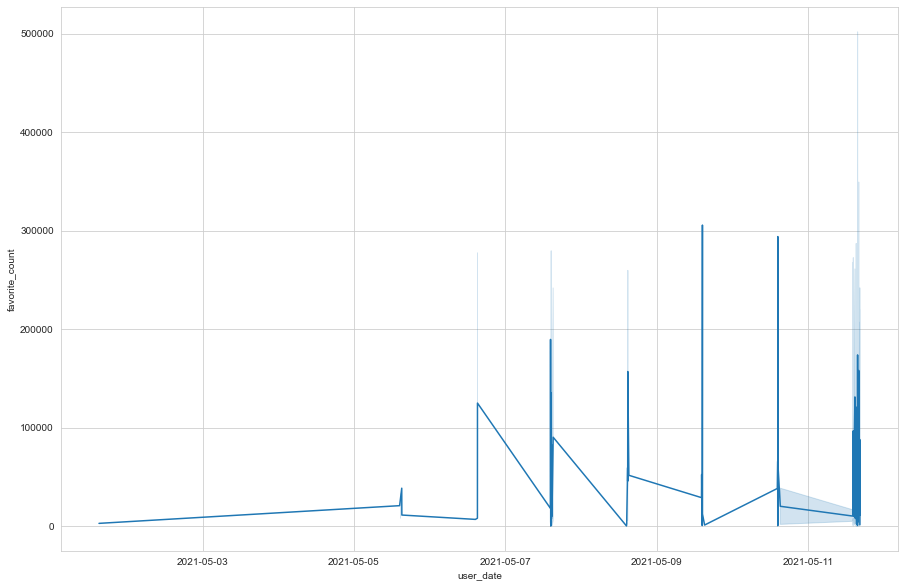

In [280]:
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
sns.lineplot(x='user_date', y='favorite_count', data=df_loc, palette='Set1')

In [136]:
df_loc.head(1)

,user_name,user_date,text,favorite_count,location,sources,followers,ver_acct,country,iso_alpha,continent,size,tweet_count,loca_City,loca_country,year,month,day,dayofweek,hour,minute,dayofyear,date_only,tweet_date
0,Angella,2021-05-11 16:26:05,EU regulators are calling on Pfizer Moderna to provide additional data related to companies COVID vaccines pote,1433,Nelson BC Canada,Twitter Web App,528,False,Canada,CAN,NA,241,241,Nelson BC Canada,Nelson BC Canada,2021,5,11,1,16,26,131,2021-05-11,2021-05-11


In [282]:
tsk_nw = df_loc.loc[:, ['user_date','favorite_count','country']]

In [283]:
fv_USA = tsk_nw[(tsk_nw['favorite_count']) & (tsk_nw['country'] == 'USA')]
fv_UK = tsk_nw[(tsk_nw['favorite_count']) & (tsk_nw['country'] == 'UK')]
fv_India = tsk_nw[(tsk_nw['favorite_count']) & (tsk_nw['country'] == 'India')]
fv_Canada = tsk_nw[(tsk_nw['favorite_count']) & (tsk_nw['country'] == 'Canada')]
fv_Aust = tsk_nw[(tsk_nw['favorite_count']) & (tsk_nw['country'] == 'Australia')]

In [284]:
fv_USA.rename(columns = {'favorite_count':'fav_USA'},inplace = True)
fv_UK.rename(columns = {'favorite_count':'fav_UK'},inplace = True)
fv_India.rename(columns = {'favorite_count':'fav_India'},inplace = True)
fv_Canada.rename(columns = {'favorite_count':'fav_Can'},inplace = True)
fv_Aust.rename(columns = {'favorite_count':'fav_Aust'}, inplace = True)

In [285]:
fig = go.Figure ()
fig.add_trace(go.Scatter(x= fv_USA.user_date,y= fv_USA.fav_USA,
                        mode = 'lines+markers',name = 'USA',
                        line = dict(color= 'blue',width = 2, 
                                    dash='dashdot')))
fig.add_trace(go.Scatter(x = fv_India.user_date, y = fv_India.fav_India,
                        mode = 'lines+markers',name = 'India',
                        line = dict(color= 'red',width = 2, 
                                    dash='dashdot')))
fig.add_trace(go.Scatter(x = fv_UK.user_date,y=fv_UK.fav_UK,
                         mode = 'lines+markers', name = 'UK'))
fig.add_trace(go.Scatter(x = fv_Canada.user_date,y=fv_Canada.fav_Can,
                         mode = 'lines', name = 'Canda',
                         line = dict(color= 'green')))
fig.add_trace(go.Scatter(x = fv_Aust.user_date,y=fv_Aust.fav_Aust,
                         mode = 'lines+markers', name = 'Australia',
                        line = dict(color= 'firebrick',width = 2, 
                                    dash='dashdot')))
fig.update_layout(title = 'Favorite_Tweet_Count By Location',
                  xaxis_title = 'Top_5 Location', yaxis_title = 'favourite count',
                 xaxis = dict(showline = True, showgrid = False, showticklabels = True),
                 yaxis = dict(zeroline = False, showline = False, showgrid = False, showticklabels = True))


In [286]:
px.line(df_loc, x='user_date' ,y='favorite_count', labels={'x': 'Date_Time','y': 'Favorite_count'}, title='Tweet-Count')

In [287]:
df_loc.reset_index(drop=True,inplace=True)
df_loc.head(1)

,user_name,user_date,text,favorite_count,location,sources,followers,ver_acct,country,tweet_count,year,month,day,dayofweek,hour,minute,dayofyear,date_only,tweet_date
0,Angella,2021-05-11 16:26:00,EU regulators are calling on Pfizer Moderna to provide additional data related to companies COVID vaccines pote,1433,Nelson BC Canada,Twitter Web App,528,False,Canada,241,2021,5,11,1,16,26,131,2021-05-11,2021-05-11


In [288]:
df.groupby('country')['text'].count().reset_index ().sort_values('text',ascending = False)

,country,text
39,Canada,241
173,United Kingdom,68
174,United States,46
0,,32
110,Nigeria,18
73,India,18
76,Ireland,11
20,Australia,8
78,Italy,8
63,France,6


In [290]:
df_loc.head()

,user_name,user_date,text,favorite_count,location,sources,followers,ver_acct,country,tweet_count,year,month,day,dayofweek,hour,minute,dayofyear,date_only,tweet_date
0,Angella,2021-05-11 16:26:00,EU regulators are calling on Pfizer Moderna to provide additional data related to companies COVID vaccines pote,1433,Nelson BC Canada,Twitter Web App,528,False,Canada,241,2021,5,11,1,16,26,131,2021-05-11,2021-05-11
1,ChristineHuddleston,2021-05-11 16:25:00,BREAKING Jason Kenney UCP Government BANS AstraZeneca despite Alberta having the HIGHEST Covid19 rate in ALL of North Ameri,3294,Toronto,Twitter for Android,14910,False,Canada,241,2021,5,11,1,16,25,131,2021-05-11,2021-05-11
2,Brittlestar,2021-05-11 16:25:00,know there arelot of people who recently got the AstraZeneca vaccine who feel snubbed after last week s com,160105,"Stratford, ON",Twitter for iPhone,84359,True,Canada,241,2021,5,11,1,16,25,131,2021-05-11,2021-05-11
3,LenaPoros,2021-05-11 16:25:00,Brazilian states halted vaccination of pregnant women on Tuesday afterdeath in Rio de Janeiro led health regulator A,16566,"Roma, Lazio",Twitter for Android,169,False,Lazio,1,2021,5,11,1,16,25,131,2021-05-11,2021-05-11
4,TjašaZavrhZombi,2021-05-11 16:25:00,Slovakia suspends AstraZeneca first dose Covid jabs health ministry says after earlier signalling it was investigating,125913,Slovenia,Twitter Web App,1297,False,Slovenia,2,2021,5,11,1,16,25,131,2021-05-11,2021-05-11


In [291]:
df_date = df['user_date'].value_counts().to_frame().reset_index().rename(columns = {'index':'date','user_date':'count'})
df_date['date'] = pd.to_datetime(df_date['date'])
df_date = df_date.sort_values('date', ascending=False)

fig = go.Figure(go.Scatter(x = df_date['date'],
                           y = df_date['count'],
                           mode = 'markers+lines',
                           name = "Submissions",
                           marker_color = 'red'))
fig.update_layout(
    title_text = 'Tweets Minutes:({} - {})'.format(df['user_date'].sort_values()[1].strftime("%d/%m/%Y %H:%M:%S"),
                                                       df['user_date'].sort_values().iloc[-1].strftime("%d/%m/%Y %H:%M:%S")), template="plotly_dark",
    title_x=0.5)
fig.show ()

In [ ]:
df

In [292]:
tweets_agg_df = df.groupby(["date_only"])["text"].count().reset_index()
tweets_agg_df.columns = ["date_only", "count"]

In [293]:
def plot_count(feature, title, df, size=1, ordered=True):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if ordered:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    else:
        g = sns.countplot(df[feature], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()    

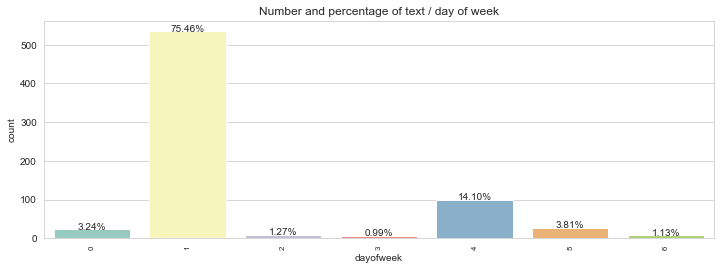

In [294]:
plot_count("dayofweek", "text / day of week", df, size=3, ordered=False)

## Sentiment Analysis with "Vader Sentiment"

Sentiment Analysis is the process of ‘computationally’ determining whether a piece of writing is positive, negative or neutral. It’s also known as opinion mining, deriving the opinion or attitude of a speaker.

**Why sentiment analysis?**

+ Business: In marketing field companies use it to develop their strategies, to understand customers’ feelings towards products or brand, how people respond to their campaigns or product launches and why consumers don’t buy some products.
- Politics: In the political field, it is used to keep track of political view, to detect consistency and inconsistency between statements and actions at the government level. It can be used to predict election results as well! .
- Public Actions: Sentiment analysis also is used to monitor and analyse social phenomena, for the spotting of potentially dangerous situations and determining the general mood of the blogosphere.

VADER Sentiment Analysis :

VADER (**Valence Aware Dictionary and sEntiment Reasoner**) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., *words*) which are generally labeled according to their semantic orientation as either positive or negative. VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.

In [297]:
"""
   function to print sentiments
   of the sentence.
   
"""
def sentiment_scores(sentence):
  
    # Create a SentimentIntensityAnalyzer object.
    sid = SentimentIntensityAnalyzer()
  
    # polarity_scores method of SentimentIntensityAnalyzer
    # oject gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid.polarity_scores(sentence)
    if sentiment_dict['compound'] >= 0.05:
        return "Positive"
  
    elif sentiment_dict['compound'] <= - 0.05:
        return "Negative"
  
    else:
        return "Neutral"

In [298]:

## Getting the sentiment of the text and assigning it to a column call sentiment
df["Sentiment"] = df["text"].apply(lambda x: sentiment_scores(x))

In [299]:
df["Sentiment"].sample(5)

207    Negative
203    Negative
573     Neutral
98      Neutral
503    Positive
Name: Sentiment, dtype: object

<AxesSubplot:title={'center':'Sentiment of Tweets'}, xlabel='Sentiment', ylabel='count'>

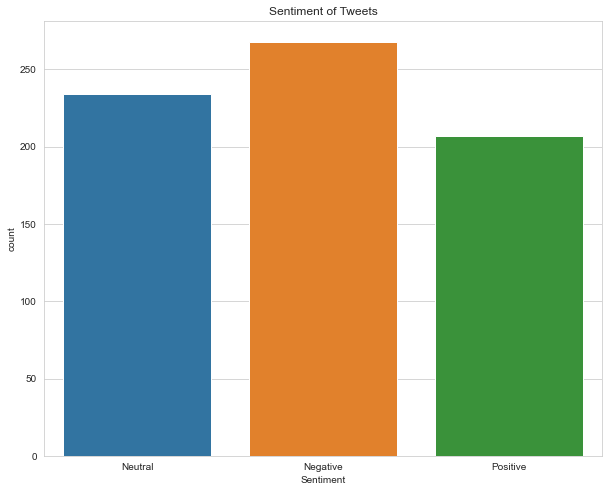

In [300]:
## plot showing the sentiment distribution

plt.figure(figsize=(10, 8))
plt.title("Sentiment of Tweets")
sns.countplot(x="Sentiment", data=df)

## END